# 3.4 基于感知的自主飞行-寻找小鸭子

## 增加目标识别功能

前面一节的课程，无人机已经能够看到环境中的物体，但如有要进一步的操作，如飞过去，扔个砖头，

还需要目标的位置，上一节是系统直接给到的，而这一节，加装了目标识别功能，无人机就可以自行获得目标在视野中的相对位置。

我们给无人机增加的函数为：
get_image() ：从无人机前置摄像头中采集图片
detect(img, object)

其输入为摄像头采集的图片，以及需要查找的目标名称object_name即可

其返回3个变量 ：
- obj_list，它是场景中检测到的对象名称的列表。
- obj_locs，每个对象在图像中的边界框坐标列表。
- img_with_box, 带有标注框的图片

另外需要注意，object只能的英文

另外，为了方便无人机自主导航，我们还添加了如下几个个基本动作：
- forward()：向前移动1米。
- turn_left()：左转10度。
- turn_right()：右转10度。


In [19]:
def detect(self, object_name):
    """
    在图像 img 上运行对象检测模型，并返回两个变量 - obj_list，它是场景中检测到的对象名称的列表。obj_locs，每个对象在图像中的边界框坐标列表。
    :param object_name:
    :return:obj_id_list,obj_locs,img_with_box #带box的图片
    """
    #step 1，读取摄像头图片，已经是RGB的了
    rgb_image = self.get_image()

    #直接使用cv图片win下有bug
    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    # 2. 生成随机文件名（含扩展名）
    file_name = f"random_{uuid.uuid4().hex}.png"  # 示例输出：random_1a2b3c4d5e.png
    cv2.imwrite(file_name, bgr_image)
    
    #step2, 目标检测
    gdino = GroundingDINOAPIWrapper(gdino_token) #使用自己的token
    prompts = dict(image=file_name, prompt=object_name)
    result = gdino.inference(prompts)
    
    #step3, 转换成需要的格式
    obj_id_list = result["categorys"]
    #[xmin, ymin, xmax, ymax]
    obj_locs = result["boxes"]
    
    #画框
    image_pil = Image.open(prompts['image'])
    img_with_box = visualize(image_pil, results)
    return obj_id_list, obj_locs,img_with_box

## 构建提示词

In [20]:
#知识库写入aisim_lession34.txt
kg_promot_file = "prompts/aisim_lession34.txt"

kg_prompt = """
想象一下您正在帮助我与 AirSim 模拟器进行交互。

我们正在控制一个实体Agent。在任何给定时间点，您都具有以下能力。您还需要输出某些请求的代码。
问题 - 向我提出一个澄清问题
原因 - 解释你为什么这样做。
代码 - 输出达到预期目标的代码命令。

场景由多个对象组成。我们可以使用以下功能，请尽可能仅使用这些功能：

洞察力：

aw.detect(object_name)：从无人机的前置摄像头渲染图像，在图像上运行对象检测模型，查找object_name，并返回3个变量 
- obj_list，它是场景中检测到的对象名称的列表。
- obj_locs，每个对象在图像中的边界框坐标列表。
- img_with_box, 带有标注框的图片，格式为PngImageFile，可以通过img_with_box.size方式获得其宽高(宽，高)。还可以使用display(img_with_box) 进行展示，但需要先引用：from IPython.display import display

注意这个函数输入的目标名称object_name只能是英文，如果需要搜索的名称是中文，则需要翻译一下

行动：
aw.takeoff() - 起飞无人机。
aw.land() - 无人机着陆。
aw.forward()：向前移动1米。
aw.turn_left()：左转10度。
aw.turn_right()：右转10度。

生成代码时，你无需考虑aw的import问题，在环境中已经声明

您不得使用任何其他假设函数。您可以使用 Python 库中的函数，例如 math、numpy 等。准备好了吗？



"""

pt_file = open(kg_promot_file, "w", encoding="utf-8")
pt_file.write(kg_prompt)
pt_file.close()

## 交互式执行

In [31]:
#先生成1个独立的airsim agent，用于人工执行代码
import airsim_wrapper
aw = airsim_wrapper.AirSimWrapper()

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)



In [22]:
#生成agent
import airsim_agent
my_agent = airsim_agent.AirSimAgent(knowledge_prompt=kg_promot_file)

In [23]:
command = "起飞"
ret = my_agent.process(command, False) #不执行代码
print("ret:", ret)

ret: 问题：无
原因：您的需求很明确，就是让无人机起飞，不需要进一步澄清。
代码：
```python
aw.takeoff()
```


In [32]:
#人工执行-----------------------------------------------------

aw.takeoff()

In [6]:
command = """
我需要你帮我找到一个目标。目标可能散布在场景中，因此，如果您没有立即找到它，一个好的策略是转身几次，看看它是否变得可见。给我代码来探索并找到小黄鸭。
"""
ret = my_agent.process(command, False) #不执行代码
print("ret:", ret)

ret: 问题 - 请问在尝试转身寻找小黄鸭时，最多允许无人机转身多少次？如果不设置上限，可能会导致程序一直运行下去。
原因 - 为了避免程序陷入无限循环，需要明确一个转身次数的上限，这样可以在一定的尝试次数后停止寻找，避免资源的过度消耗。
代码 - 以下是在假设最多转身 36 次（即转一圈）的情况下的代码：
```python
import math

# 起飞
aw.takeoff()

# 最多尝试转身 36 次
max_turns = 36
turn_count = 0

while turn_count < max_turns:
    # 检测小黄鸭，注意将中文名称翻译为英文
    obj_list, obj_locs, img_with_box = aw.detect('rubber duck')
    if 'rubber duck' in obj_list:
        print("找到了小黄鸭！")
        break
    else:
        # 未找到则右转
        aw.turn_right()
        turn_count += 1

if turn_count == max_turns:
    print("在规定的尝试次数内未找到小黄鸭。")

```


找到了 rubber duck！


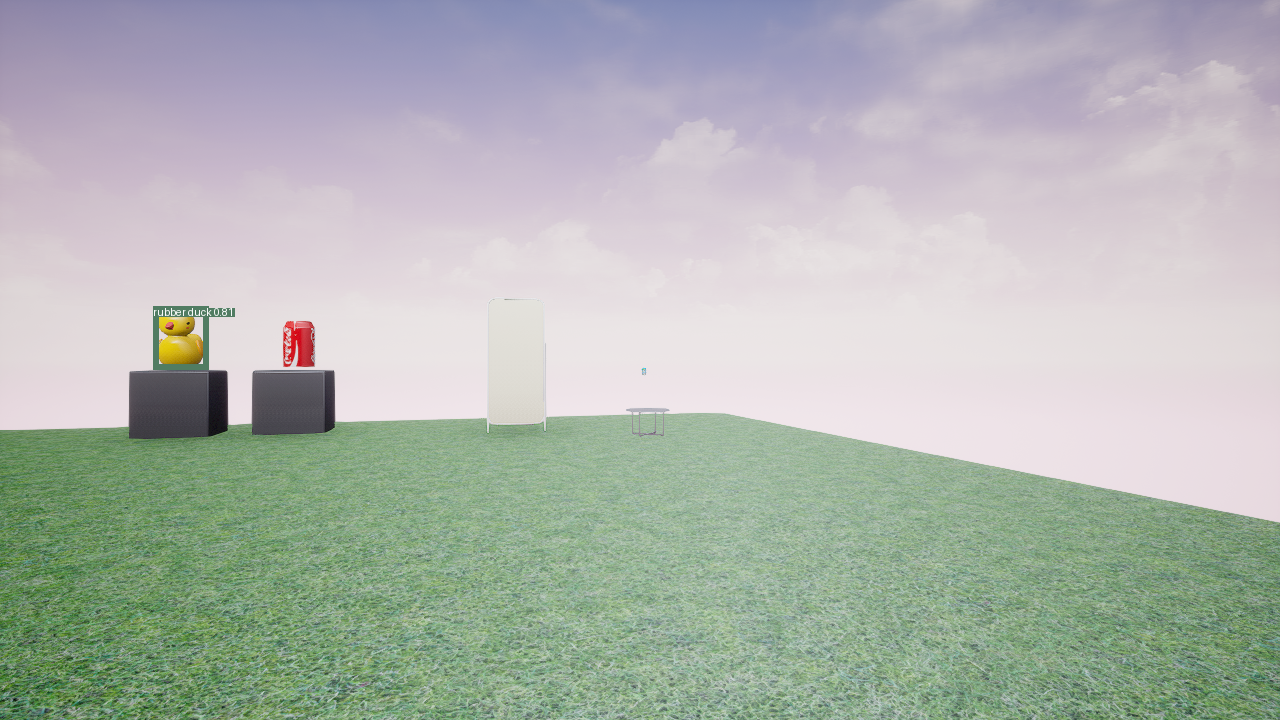

In [46]:
import time
from IPython.display import display

# 翻译中文名称为英文,检测小黄鸭（英文为 "rubber duck"）
target_name = "rubber duck"
max_turns = 36  # 假设最多转身36次，可根据后续澄清修改
turn_count = 0

while True:
    obj_list, obj_locs,img_with_box  = aw.detect(target_name)
    if target_name in obj_list:
        print(f"找到了 {target_name}！")
        display(img_with_box)
        break
    elif turn_count < max_turns:
        aw.turn_right()
        turn_count += 1
    else:
        print(f"经过 {max_turns} 次转身仍未找到 {target_name}。")
        break

In [25]:
command = """
太棒了！现在假设我们确实找到了小黄鸭。现在我想向它迈进。我们拥有的唯一信息是图像中小黄鸭边界框的位置。你能给我代码来实现这一点吗？
"""
ret = my_agent.process(command, False) #不执行代码
print("ret:", ret)

ret: 问题：图像的坐标系原点位置以及边界框坐标的表示方式是怎样的呢（例如是左上角为原点，坐标是(xmin, ymin, xmax, ymax) 这种形式吗）？另外，图像的分辨率是多少呢？
原因：要根据边界框位置让无人机向小黄鸭迈进，需要明确图像坐标系和边界框坐标的具体表示形式，同时图像分辨率对于计算无人机的转向和移动方向很关键，不同的分辨率和坐标表示会影响到后续的计算逻辑。
代码：由于缺少上述关键信息，暂时无法给出完整准确的代码。不过下面是一个大致的实现思路代码框架，假设边界框坐标是 (xmin, ymin, xmax, ymax) 形式，图像原点在左上角，图像宽度为 `img_width`：
```python
import math

# 假设已经调用 detect 函数得到了小黄鸭的边界框信息
obj_list, obj_locs, img_with_box = aw.detect("rubber duck")
if "rubber duck" in obj_list:
    # 找到小黄鸭的边界框
    index = obj_list.index("rubber duck")
    xmin, ymin, xmax, ymax = obj_locs[index]
    # 计算边界框中心的 x 坐标
    center_x = (xmin + xmax) / 2
    img_width = img_with_box.size[0]
    # 计算偏移比例
    offset_ratio = (center_x - img_width / 2) / (img_width / 2)
    # 根据偏移比例计算需要转动的角度
    turn_angle = int(offset_ratio * 45)  # 最大转动 45 度
    if turn_angle > 0:
        # 右转
        num_turns = math.ceil(turn_angle / 10)
        for _ in range(num_turns):
            aw.turn_right()
    elif turn_angle < 0:
        # 左转
        num_turns = math

['rubber duck']
img_center_x 640.0 duck_center_x 363.5403137207031
['rubber duck']


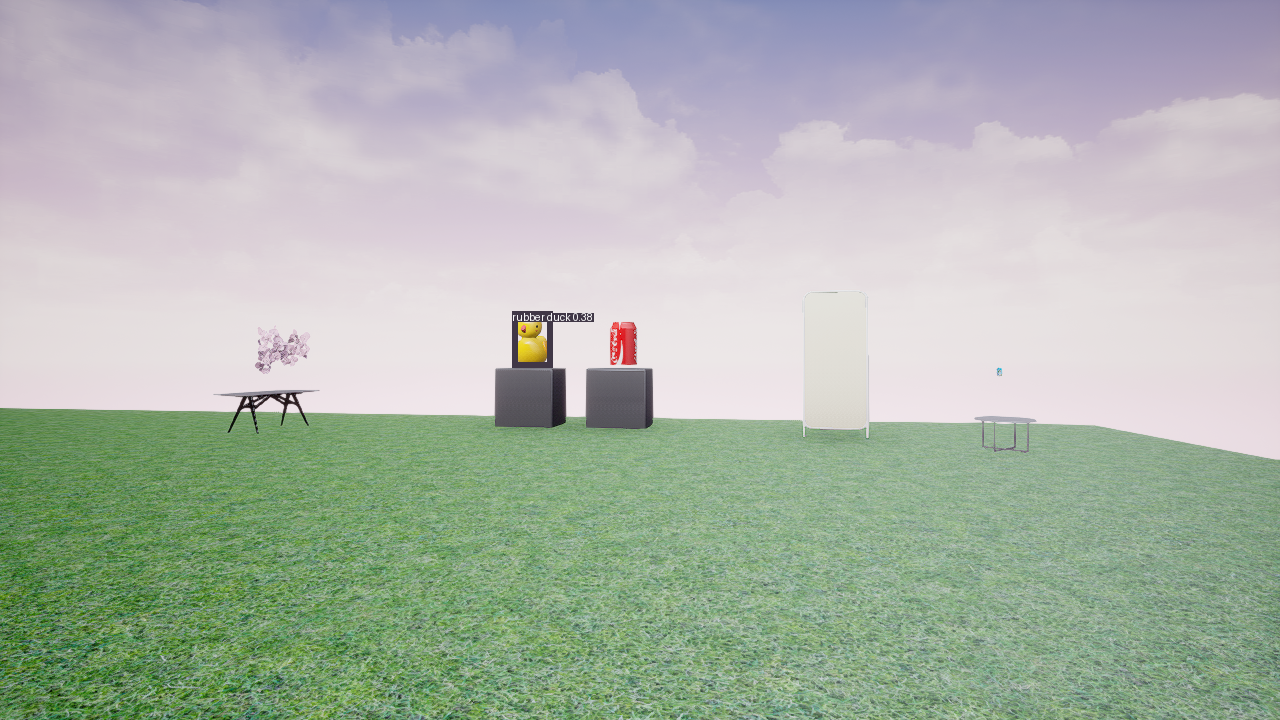

img_center_x 640.0 duck_center_x 532.3721923828125
['rubber duck']


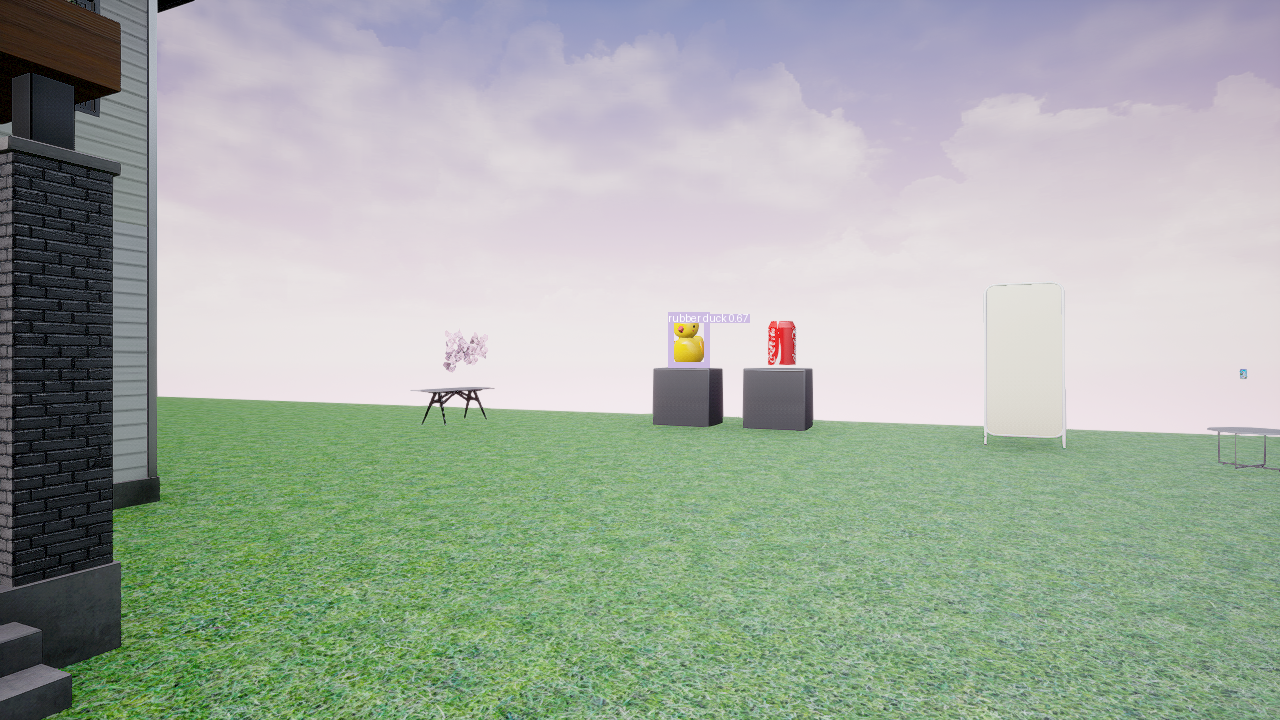

方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进
方向正确，向前进


In [50]:
import numpy as np

# 假设之前已经检测到小黄鸭，这里使用之前检测得到的变量
obj_list, obj_locs, img_with_box = aw.detect('rubber duck')
print(obj_list)

# 找到小黄鸭边界框的索引
duck_index = obj_list.index('rubber duck')
duck_bbox = obj_locs[duck_index]

# 计算图像的中心
img_width,img_height = img_with_box.size
img_center_x = img_width / 2

# 计算小黄鸭边界框的中心
duck_center_x = (duck_bbox[0] + duck_bbox[2]) / 2

# 设定一个误差范围，当小黄鸭中心与图像中心的偏差在这个范围内时，认为无人机正对着小黄鸭
error_threshold = 100

for i in range(10):#最多10米

    #确定方向
    while abs(duck_center_x - img_center_x) > error_threshold:
        print("img_center_x",img_center_x,"duck_center_x",duck_center_x)
        if duck_center_x < img_center_x:
            # 小黄鸭在图像左侧，左转
            aw.turn_left()
        else:
            # 小黄鸭在图像右侧，右转
            aw.turn_right()
        
        # 再次检测小黄鸭以更新边界框位置
        obj_list, obj_locs, img_with_box = aw.detect('rubber duck')
        print(obj_list)

        if "rubber duck" in obj_list:
            display(img_with_box)
            duck_index = obj_list.index('rubber duck')
            duck_bbox = obj_locs[duck_index]
            duck_center_x = (duck_bbox[0] + duck_bbox[2]) / 2

    # 当无人机正对着小黄鸭时，向前移动
    print("方向正确，向前进")
    aw.forward()
    # 再次检测小黄鸭以更新边界框位置
    obj_list, obj_locs, img_with_box = aw.detect('rubber duck')
    print(obj_list)
    if "rubber duck" in obj_list:
        display(img_with_box)
        duck_index = obj_list.index('rubber duck')
        duck_bbox = obj_locs[duck_index]
        duck_center_x = (duck_bbox[0] + duck_bbox[2]) / 2

In [51]:
aw.set_yaw(0)

可以看到，基于单个摄像头的目标识别功能，大模型可以基于最简单的运动控制（pid的一种简化），来飞向目标小鸭子

大致原理如下：

<img src='img/duck.jpg' width='640px' />

也就是说，无人机摄像头采集的图片，左上角为原点，也就是(0,0)坐标，

如果小鸭子位于图片中心的左侧，则无人机向左转，如果位于图片中心的右侧，则向右转。

然后向前移动一段距离，再进行视觉判断。

大模型生成的代码基本框架是没问题的，但要完美的执行，一般还需要多次提示。

## 思考问题
这一章，我们给了无人机视觉认知和目标识别能力

如果我们再给无人机一个拿东西的能力take(),以及放东西的能力drop()

然后我给无人机说 "我渴了"

无人机该如何响应呢？